In [12]:
%run PVModel_functions.ipynb

In [13]:
%run PVsystem_filterfunction_jack-may.ipynb

In [14]:
#This cell imports all the necessary packages & module data
import pandas as pd 
import numpy as np
from numpy import median
from datetime import datetime
import datatools
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
import pvlib
import pvanalytics
import math
import pvpltools
import seaborn as sns
from pvpltools import iec61853
from pvpltools.module_efficiency import adr, heydenreich, motherpv, pvgis, mpm5, mpm6, bilinear
from pvpltools.module_efficiency import fit_efficiency_model, fit_bilinear

%matplotlib inline 
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

mpl.rcParams['font.size']=12
mpl.rcParams['lines.linewidth']=1
mpl.rcParams['xtick.labelsize']=10
#mpl.rcParams['font.weight']='bold'
mpl.rcParams['axes.titlesize']=22
sns.set(rc={'figure.figsize':(12,7)})

mod_names = 'LG', 'Panasonic', 'Can270', 'Can275', 'HanQPlus', 'HanQPeak', 'MissionSolar'#, 'Jinko'
mettablename =  'dbo.SNLA_Met_DataOut'

In [81]:
#Generate empty df to store appended results
newresults=[]

In [ ]:
for mod_name in mod_names:
    
    
   #Reads in an excel file of all necessary module coefficients, string lengths, system dates, etc
    mod_info = pd.read_excel('module_coefficients.xlsx')
    mod_info.index = mod_info['Manufacturer']
    del mod_info['Manufacturer']
    #defines the specific module given the previous user input and module coefficients file
    module = mod_info[mod_name]
    systablename = module['table_name']
    start = '2018-01-01 00:00:00-07:00'
    end = '2019-01-01 00:00:00-07:00'
    #year='2020'
    
    #Import sys & met databases & merge into one df
    df = sys_met_data(mettablename, systablename, start, end)
    
    #Calculate solpos & other environmental data, like airmass, aoi, and differnt poa components
    pres = df['Pressure_mBar_Avg']*100
    sdf = calc_sol_data(time=df.index, latitude=module['latitude'], longitude=module['longitude'],
                    temperature=df['Temp_C_Avg'], tilt=module['tilt'], altitude=module['altitude'])
    #Calculate Environmental Data i.e. airmass, pressure, POA irradiance compenents etc.
    edf = calc_env_data(tilt=module['tilt'],altitude=module['altitude'], sur_azimuth=module['surface_azimuth'], 
                    sol_azimuth=sdf['azimuth'], zenith=sdf['apparent_zenith'], DNI=df['Direct_Wm2_Avg'], 
                    GHI=df['Global_Wm2_Avg'], DHI=df['Diffuse_Wm2_Avg'], DNI_extra=sdf['dni_extra'], model ='haydavies')

    #Calculate airmass and add this to the Environmental Data
    edf['am_abs'] = pvlib.atmosphere.get_absolute_airmass(airmass_relative=edf['airmass'], pressure=pres)
    
    #Solar Elevation Filter
    sol_elev_mask = simple_filter(sdf, 'apparent_elevation', lower=15, upper=90, apply=False)
    df = df.where(sol_elev_mask, np.nan)
    
    
    #Calculate effective irradiance and cell temperature models using
    sapm_data = sapm_param(POA_global=edf['poa_global'], POA_direct=edf['poa_direct'], POA_diffuse=edf['poa_diffuse'], 
                       amb_temp=df.Temp_C_Avg, ws_avg=df.WS_ms_Mean, am_abs=edf['am_abs'], aoi=edf['aoi'], module=module)
    df = df.merge(sapm_data, how='inner', left_index=True, right_index=True)
    df = df[~df.index.duplicated(keep='first')]
    
    #Apply physical Filters
    df = simple_filter(sys=df, variable='eff_irr', lower=50, upper=1200, apply=True)
    df = simple_filter(sys=df,variable='tcell', lower=-40, upper=85, apply=True)
    df = simple_filter(sys=df, variable='Temp_C_Avg', lower=-40, upper=85, apply=True)
    
    #Removing individual days that cause large errors due to shading, snow, etc

    #filter out pole shading 
    shade_list = ['Can270', 'HanQPlus']
    if mod_name in shade_list:
        shade_start = '2020-10-06 00:00:00-07:00'
        shade_end = '2020-11-02 00:00:00-07:00'
        shask = (df.index > shade_start) & (df.index <= shade_end)
        df = df.loc[~shask]
    
    #Filtering out days in 2019 that caused large outliers - could be due to snow on modules    
    dec_list = ['Panasonic', 'LG']
    if mod_name in dec_list:
        dec_start = '2019-12-29 00:00:00-07:00'
        dec_end = '2019-12-30 00:0:00-07:00'
        dec_mask = (df.index > dec_start) & (df.index <= dec_end)
        df = df.loc[~dec_mask]
    
    #remove feb 23 2019
    feb_start = '2019-02-23 00:00:00-07:00'
    feb_end = '2019-02-24 10:00:00-07:00'
    feb_mask = (df.index > feb_start) & (df.index <= feb_end)
    df = df.loc[~feb_mask] 

    #remove dec 2 2018
    dec_start = '2018-12-02 00:00:00-07:00'
    dec_end = '2018-12-02 23:59:00-07:00'
    dec_mask = (df.index > dec_start) & (df.index <= dec_end)
    df = df.loc[~dec_mask]

    #remove dec 26 2018
    dec_start = '2018-12-26 00:00:00-07:00'
    dec_end = '2018-12-26 23:59:00-07:00'
    dec_mask = (df.index > dec_start) & (df.index <= dec_end)
    df = df.loc[~dec_mask]

    #Removing Days in 2020 that had extremely large differences 
    #remove sep 21 2020
    sep_start = '2020-09-21 00:00:00-07:00'
    sep_end = '2020-09-22 23:00:00-07:00'
    sep_mask = (df.index > sep_start) & (df.index <= sep_end)
    df = df.loc[~sep_mask]

    #remove feb 5 2020
    feb_start = '2020-02-05 00:00:00-07:00'
    feb_end = '2020-02-05 23:00:00-07:00'
    feb_mask = (df.index > feb_start) & (df.index <= feb_end)
    df = df.loc[~feb_mask]
    
    
    ##### Filter out the data points with a certain ratio of current to irradiance
    string_is ='str_1_i', 'str_2_i', 'str_3_i', 'str_4_i'
    ratio_names = 'ratio str_1_i to eff_irr', 'ratio str_2_i to eff_irr', 'ratio str_3_i to eff_irr', 'ratio str_4_i to eff_irr'

    for string_i in string_is:
        #Calculate the ratio at each given timestep
        df['ratio' + ' ' + string_i + ' ' 'to eff_irr'] = df[module[string_i]]/df['eff_irr']
        #Create a df with no NaNs to calculate the slope of trendline between current and irradiance
        nadf = df.dropna(inplace=False)
        z = np.polyfit(nadf['eff_irr'], nadf[module[string_i]],1)
        #Calculate lower/upper bounds
        lower = z[0]-(z[0]*0.3)
        upper = (z[0]*0.3) + z[0]
        #Use previously defined column name to filter values
        ratio_name ='ratio' + ' ' + string_i + ' ' 'to eff_irr'
        df = simple_filter(df, ratio_name, lower=lower, upper=upper, apply=True)  
    
    #This loop will cycle through all 4 strings since performance may vary slightly for each string    
    
   #Generate a results dataframe and add measured values
    str_1 = meas_val(df[module['str_1_v']],df[module['str_1_i']])
    str_2 = meas_val(df[module['str_2_v']],df[module['str_2_i']])
    str_3 = meas_val(df[module['str_3_v']],df[module['str_3_i']])
    str_4 = meas_val(df[module['str_4_v']],df[module['str_4_i']])
    
    
    #Calcualte SAPM results and add to df
    dc = sapm(eff_irr=df['eff_irr'], tcell=df['tcell'], module=module)
    sapm_results = sapm_p(v_mp=dc['v_mp'], i_mp=dc['i_mp'], str_len=module['str_len']).to_frame()

    sapm_results.rename(columns = {0 : 'Modeled Power'}, inplace = True)
    sapm_results['Str_1'] = str_1
    sapm_results['Str_2'] = str_2
    sapm_results['Str_3'] = str_3
    sapm_results['Str_4'] = str_4
    sapm_results['Time'] = sapm_results.index
    sapm_results['Year'] = sapm_results.index.year
    sapm_results['Model Name'] = 'SAPM'
    sapm_results['System'] = mod_name
    newresults.append(sapm_results)
    
    #Calculate PVWatts results and add to df
    pvw_results = (pvwatts(POA_eff = df['eff_irr'], cell_temp = df['tcell'], stc_mod_p = module['Power'], 
                Gpmp = module['Gpmp'],str_len = module['str_len'],temp_ref=25.0 )).to_frame()

    pvw_results.rename(columns = {0 : 'Modeled Power'}, inplace = True)
    pvw_results['Str_1'] = str_1
    pvw_results['Str_2'] = str_2
    pvw_results['Str_3'] = str_3
    pvw_results['Str_4'] = str_4
    pvw_results['Time'] = pvw_results.index
    pvw_results['Year'] = pvw_results.index.year
    pvw_results['Model Name'] = 'PVW'
    pvw_results['System'] = mod_name
    newresults.append(pvw_results)
    
    #Calculate parameters to use in single diode models
    cec_ivt = pvlib.ivtools.sdm.fit_cec_sam(celltype=module['cell_type'], v_mp=module['v_mp'], i_mp=module['i_mp'],
                                v_oc=module['v_oc'], i_sc=module['i_sc'],alpha_sc=module['alpha_sc'], 
                                beta_voc=module['beta_voc'],gamma_pmp=(module['gamma_pmp']),
                                cells_in_series=module['Cells_in_Series'])

    #Calculate parameters necessary to input into single diode model
    cec_param = pvlib.pvsystem.calcparams_cec(effective_irradiance=df['eff_irr'], 
            temp_cell=df['tcell'], alpha_sc=module['alpha_sc'],a_ref=cec_ivt[4], I_L_ref=cec_ivt[0], 
            I_o_ref=cec_ivt[1], R_sh_ref=cec_ivt[3],R_s=cec_ivt[2],Adjust=cec_ivt[5],EgRef=1.121)
    #Calculate power using single diode model
    cec_p = pvlib.pvsystem.singlediode(photocurrent = cec_param[0], saturation_current = cec_param[1], resistance_series =
                           cec_param[2], resistance_shunt = cec_param[3], nNsVth = cec_param[4], method = 'newton')
    #Calculate string power
    cec_results = sdm(p_mp=cec_p['p_mp'], str_len=module['str_len']).to_frame()


    cec_results.rename(columns = {'p_mp' : 'Modeled Power'}, inplace = True)
    cec_results['Str_1'] = str_1
    cec_results['Str_2'] = str_2
    cec_results['Str_3'] = str_3
    cec_results['Str_4'] = str_4
    cec_results['Time'] = cec_results.index
    cec_results['Year'] = cec_results.index.year
    cec_results['Model Name'] = 'CEC'
    cec_results['System'] = mod_name
    newresults.append(cec_results)
    
   #Calculate Desoto results and add to df

    #Calculate parameters necessary to input into single diode model
    ds_param = pvlib.pvsystem.calcparams_desoto(effective_irradiance=df['eff_irr'], 
            temp_cell=df['tcell'], alpha_sc=module['alpha_sc'],a_ref=cec_ivt[4], I_L_ref=cec_ivt[0], 
            I_o_ref=cec_ivt[1], R_sh_ref=cec_ivt[3],R_s=cec_ivt[2], EgRef=1.121)
    #Calculate power using single diode model
    ds_p = pvlib.pvsystem.singlediode(photocurrent = ds_param[0], saturation_current = ds_param[1], resistance_series =
                           ds_param[2], resistance_shunt = ds_param[3], nNsVth = ds_param[4], method = 'newton')
    #Calculate string power
    des_results = sdm(p_mp=ds_p['p_mp'], str_len=module['str_len']).to_frame()

    des_results.rename(columns = {'p_mp' : 'Modeled Power'}, inplace = True)
    des_results['Str_1'] = str_1
    des_results['Str_2'] = str_2
    des_results['Str_3'] = str_3
    des_results['Str_4'] = str_4
    des_results['Time'] = des_results.index
    des_results['Year'] = des_results.index.year
    des_results['Model Name'] = 'DES'
    des_results['System'] = mod_name
    newresults.append(des_results)
    
   #Calculte PVSystem results and add to df

    #Calculate I_o_ref
    Io = -((module['i_mp']+(module['v_mp'] + module['i_mp']*module['R_s'])/module['R_sh_ref'])-module['i_sc'])/\
            (np.exp((1.60217662e-19)*(module['v_mp']+module['i_mp']*module['R_s'])/\
            (module['Cells_in_Series']*module['gamma_ref']*(1.38064852e-23)*(298.15)))-1)
    #Calculate parameters necessary to input into single diode model
    pvs_param = pvlib.pvsystem.calcparams_pvsyst(effective_irradiance=df['eff_irr'],temp_cell=df['tcell'], 
            alpha_sc=module['alpha_sc'],gamma_ref=module['gamma_ref'],mu_gamma=module['mu_gamma'], 
            I_L_ref=module['i_sc'],I_o_ref=Io,R_sh_ref=module['R_sh_ref'], R_sh_0=module['R_sh_0'],
            R_s=module['R_s'],cells_in_series=module['Cells_in_Series'], EgRef=1.121)
    #Calculate power using single diode model
    pvs_p = pvlib.pvsystem.singlediode(photocurrent = pvs_param[0], saturation_current = pvs_param[1], resistance_series =
                           pvs_param[2], resistance_shunt = pvs_param[3], nNsVth = pvs_param[4], method = 'newton')
    #Calculate string power
    pvs_results = sdm(p_mp=pvs_p['p_mp'], str_len=module['str_len']).to_frame()

    pvs_results.rename(columns = {'p_mp' : 'Modeled Power'}, inplace = True)
    pvs_results['Str_1'] = str_1
    pvs_results['Str_2'] = str_2
    pvs_results['Str_3'] = str_3
    pvs_results['Str_4'] = str_4
    pvs_results['Time'] = pvs_results.index
    pvs_results['Year'] = pvs_results.index.year
    pvs_results['Model Name'] = 'PVS'
    pvs_results['System'] = mod_name
    newresults.append(pvs_results)
    
    
    #Import matrix of measurement data
    measurements_file = 'Sandia_PV_Module_P-Matrix-and-TempCo-Data_2019.xlsx'
    matrix = pd.read_excel(measurements_file, sheet_name = mod_name, usecols='B,C,H', header=None, skiprows=5, nrows=27)
    matrix.columns = ['temperature', 'irradiance', 'p_mp']
    # calculate efficiency from power
    matrix = matrix.eval('eta = p_mp / irradiance')
    eta_stc = matrix.query('irradiance == 1000 and temperature == 25').eta
    matrix.eta /= eta_stc.values
    # just keep the columns that are needed
    matrix = matrix[['irradiance', 'temperature', 'eta']]
    
    
   #Calculate ADR results and add to df
    #Determine the parameters for the eff. model using non-linear least squares fit
    popt, pcov = fit_efficiency_model(irradiance=matrix.irradiance,temperature=matrix.temperature,eta=matrix.eta,model=adr)
    #Calculate eff. using adr model
    adr_eff = adr(df['eff_irr'],df['tcell'],*popt)
    #Calculate power given the above adr eff. 
    adr_results = ((df['eff_irr']/1000) * (adr_eff) * (module['Power']) *12).to_frame()

    adr_results.rename(columns = {'eff_irr' : 'Modeled Power'}, inplace = True)
    adr_results['Str_1'] = str_1
    adr_results['Str_2'] = str_2
    adr_results['Str_3'] = str_3
    adr_results['Str_4'] = str_4
    adr_results['Time'] = adr_results.index
    adr_results['Year'] = adr_results.index.year
    adr_results['Model Name'] = 'ADR'
    adr_results['System'] = mod_name
    newresults.append(adr_results)
    
    
    #Calculate Heydenreich results and add to df
    #Determine the parameters for the eff. model using non-linear least squares fit
    popt, pcov = fit_efficiency_model(irradiance=matrix.irradiance, temperature=matrix.temperature,
                                    eta=matrix.eta, model=heydenreich)
    hey_eff = heydenreich(df['eff_irr'], df['tcell'], *popt)
    hey_results = ((df['eff_irr']/1000) * (hey_eff) * (module['Power']) *12).to_frame()

    hey_results.rename(columns = {'eff_irr' : 'Modeled Power'}, inplace = True)
    hey_results['Str_1'] = str_1
    hey_results['Str_2'] = str_2
    hey_results['Str_3'] = str_3
    hey_results['Str_4'] = str_4
    hey_results['Time'] = hey_results.index
    hey_results['Year'] = hey_results.index.year
    hey_results['Model Name'] = 'HEY'
    hey_results['System'] = mod_name
    newresults.append(hey_results)
            
    
    #Calculate MotherPV results and add to df
    #Determine the parameters for the eff. model using non-linear least squares fit
    popt, pcov = fit_efficiency_model(irradiance=matrix.irradiance,temperature=matrix.temperature,eta=matrix.eta,model=motherpv)
    mother_eff = motherpv(df['eff_irr'], df['tcell'], *popt)
    mot_results = ((df['eff_irr']/1000) * (mother_eff) * (module['Power']) * 12).to_frame()

    mot_results.rename(columns = {'eff_irr' : 'Modeled Power'}, inplace = True)
    mot_results['Str_1'] = str_1
    mot_results['Str_2'] = str_2
    mot_results['Str_3'] = str_3
    mot_results['Str_4'] = str_4
    mot_results['Time'] = mot_results.index
    mot_results['Year'] = mot_results.index.year
    mot_results['Model Name'] = 'MOT'
    mot_results['System'] = mod_name
    newresults.append(mot_results)
    
    
    #Calculate PVGIS results and add to df
    #Determine the parameters for the eff. model using non-linear least squares fit
    popt, pcov = fit_efficiency_model(irradiance=matrix.irradiance,temperature=matrix.temperature,eta=matrix.eta,model=pvgis)
    pvgis_eff = pvgis(df['eff_irr'], df['tcell'], *popt)
    pvg_results = ((df['eff_irr']/1000) * (pvgis_eff) * (module['Power']) *12).to_frame()
    
    pvg_results.rename(columns = {'eff_irr' : 'Modeled Power'}, inplace = True)
    pvg_results['Str_1'] = str_1
    pvg_results['Str_2'] = str_2
    pvg_results['Str_3'] = str_3
    pvg_results['Str_4'] = str_4
    pvg_results['Time'] = pvg_results.index
    pvg_results['Year'] = pvg_results.index.year
    pvg_results['Model Name'] = 'PVG'
    pvg_results['System'] = mod_name
    newresults.append(pvg_results)
    
    
   #Calculate MPM5 results and add to df
    #Determine the parameters for the eff. model using non-linear least squares fit
    popt, pcov = fit_efficiency_model(irradiance=matrix.irradiance,temperature=matrix.temperature,eta=matrix.eta,model=mpm5)
    mpm5_eff = mpm5(df['eff_irr'], df['tcell'], *popt)
    mpm5_results = ((df['eff_irr']/1000) * (mpm5_eff) * (module['Power']) *12).to_frame()
    
    mpm5_results.rename(columns = {'eff_irr' : 'Modeled Power'}, inplace = True)
    mpm5_results['Str_1'] = str_1
    mpm5_results['Str_2'] = str_2
    mpm5_results['Str_3'] = str_3
    mpm5_results['Str_4'] = str_4
    mpm5_results['Time'] = mpm5_results.index
    mpm5_results['Year'] = mpm5_results.index.year
    mpm5_results['Model Name'] = 'MPM5'
    mpm5_results['System'] = mod_name
    newresults.append(mpm5_results)
    
    
    #Calculate MPM6 results and add to df
    #Determine the parameters for the eff. model using non-linear least squares fit
    popt, pcov = fit_efficiency_model(irradiance=matrix.irradiance,temperature=matrix.temperature,eta=matrix.eta,model=mpm6)
    mpm6_eff = mpm6(df['eff_irr'], df['tcell'], *popt)
    mpm6_results = ((df['eff_irr']/1000) * (mpm6_eff) * (module['Power']) *12).to_frame()

    mpm6_results.rename(columns = {'eff_irr' : 'Modeled Power'}, inplace = True)
    mpm6_results['Str_1'] = str_1
    mpm6_results['Str_2'] = str_2
    mpm6_results['Str_3'] = str_3
    mpm6_results['Str_4'] = str_4
    mpm6_results['Time'] = mpm6_results.index
    mpm6_results['Year'] = mpm6_results.index.year
    mpm6_results['Model Name'] = 'MPM6'
    mpm6_results['System'] = mod_name
    newresults.append(mpm6_results)
    
    #Calculate Bilinear results and add to df
    #Determine the parameters for the eff. model using non-linear least squares fit
    interpolator = fit_bilinear(**matrix)
    bilinear_eff = bilinear(df['eff_irr'], df['tcell'], interpolator)
    bil_results = ((df['eff_irr']/1000) * (bilinear_eff) * (module['Power']) * 12).to_frame()
    
    bil_results.rename(columns = {'eff_irr' : 'Modeled Power'}, inplace = True)
    bil_results['Str_1'] = str_1
    bil_results['Str_2'] = str_2
    bil_results['Str_3'] = str_3
    bil_results['Str_4'] = str_4
    bil_results['Time'] = bil_results.index
    bil_results['Year'] = bil_results.index.year
    bil_results['Model Name'] = 'BIL'
    bil_results['System'] = mod_name
    newresults.append(bil_results)
    
    print(mod_name)
    

In [83]:
meta = pd.concat(newresults, ignore_index=True)
meta.index=meta['Time']

In [84]:
#Calculate MAPE/MBE
    
    
strings = ['Str_1','Str_2','Str_3','Str_4']
for string in strings:
    meta['Diff ' + string] = (meta['Modeled Power'] - meta[string])
meta['MBE'] = (meta['Diff Str_1'] + meta['Diff Str_2'] + meta['Diff Str_3'] + meta['Diff Str_4'])/4
for string in strings:
     meta['Abs%Error ' + string] = 100* abs((meta['Modeled Power'] - meta[string])/(meta[string]))
meta['MAPE %'] = ((meta.iloc[:,[14,15,16,17]].mean(axis=1)))
    


In [ ]:
#meta.to_hdf('sys_mape.h5', key='meta', complib='zlib', complevel=5 )

Text(0, 0.5, 'MBE (W)')

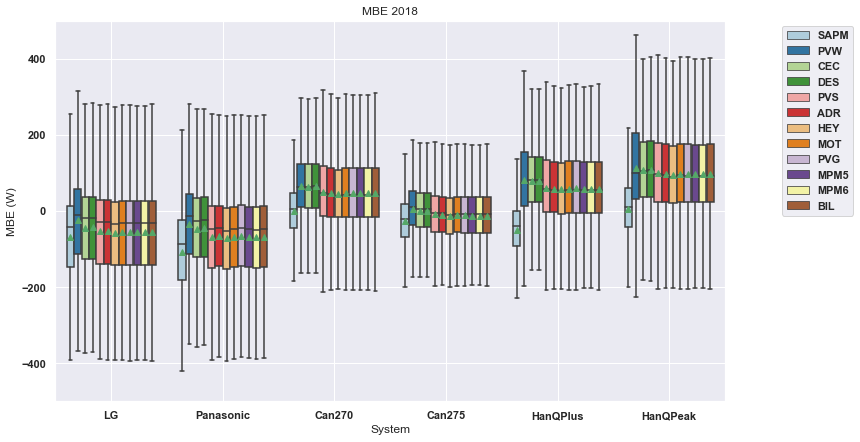

In [89]:
ax = sns.boxplot(x='System', y='MBE', data = meta, hue='Model Name', showmeans=True, showfliers=False, palette='Paired')
ax.set_ylim([-500,500])
ax.grid(True)
ax.legend(bbox_to_anchor= (1.2, 1), loc='upper right')
ax.set_title('MBE 2018')
ax.set_ylabel('MBE (W)')

Text(0.5, 1.0, 'MAPE % 2018')

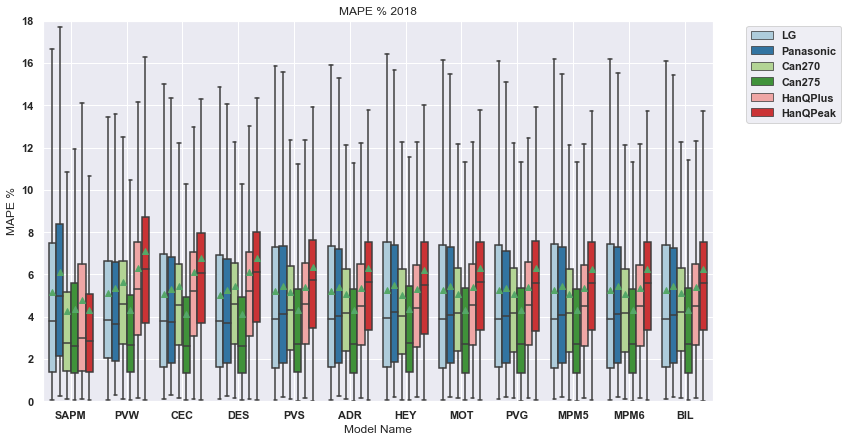

In [90]:
ax = sns.boxplot(x='Model Name', y='MAPE %', data = meta, hue='System', showmeans=True, showfliers=False,palette='Paired')
ax.set_ylim([0,18])
ax.grid(True)
ax.legend(bbox_to_anchor= (1.2, 1), loc='upper right')
ax.set_title('MAPE % 2018')